In [439]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 


In [440]:
df = pd.read_csv('/Users/rileywilson/Documents/tennis_analysis/WTA_modeling/database/WTA_and_ITF_match_records_all_features.csv')

/var/folders/3_/dqdbgzyx0rlg0nqjsqqbrdlr0000gn/T/ipykernel_32973/2809734883.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/rileywilson/Documents/tennis_analysis/WTA_modeling/database/WTA_and_ITF_match_records_all_features.csv')


In [441]:
#Excluding all Fed cup, BJK cup, and non-WTA matches

df['fed/bjk'] = df['tourney_name'].apply(lambda x: x.startswith(('bjk', 'fed')))

df = df[(df['WTA'] == True) & df['fed/bjk'] == False]

In [442]:
#now let's make a year column and figure out how each tournament played every year. 

df['year'] = df['tourney_date'].apply(lambda x: int(x.split('-')[0]))



In [443]:
#Every tournament needs to have a rolling ace deviation 
#I'll drop all the rows that have a nan in the w_ace or l_ace column 

def tournament_speeds(df):
    #returns a dataframe mulitindexed by tournament and year. 
    #the "observed_over_expected" column contains how many aces 
    #were observed that tournament over how many we would have 
    #expected given the entrants. 

    
    df = df.dropna(subset = ['w_ace', 'l_ace'], axis = 0)
    #we'll tally up all of a player's aces and the matches she's played. 
    #then we'll take the ratio and return that as a dictionary. 

    #resetting index 
    df.reset_index(inplace = True, drop = True)

    w_avg_ace_rate = []
    w_matches_played = []
    
    l_avg_ace_rate = []
    l_matches_played = [] 

    #creating player ace dictionary. Each dictionary will hold a list with two numbers. The first is a player's 
    #career aces. The second is her career match count. 

    player_dict = {} 

    for i in df.index:
        #if a player doesn't have an entry, we create one 

        if df.iloc[i]['winner_name'] not in player_dict.keys():
            player_dict[df.iloc[i]['winner_name']] = [0,0] 

        if df.iloc[i]['loser_name'] not in player_dict.keys():
            player_dict[df.iloc[i]['loser_name']] = [0,0] 

        #putting in her to-date ace rate:
        #winner
        if player_dict[df.iloc[i]['winner_name']][1] == 0:
            w_avg_ace_rate.append(0)
        else:
            w_avg_ace_rate.append(player_dict[df.iloc[i]['winner_name']][0] / player_dict[df.iloc[i]['winner_name']][1])

        w_matches_played.append(player_dict[df.iloc[i]['winner_name']][1]) 

        #loser
        if player_dict[df.iloc[i]['loser_name']][1] == 0:
            l_avg_ace_rate.append(0)
        else:
            l_avg_ace_rate.append(player_dict[df.iloc[i]['loser_name']][0] / player_dict[df.iloc[i]['loser_name']][1])

        l_matches_played.append(player_dict[df.iloc[i]['loser_name']][1]) 

        #now we increment the career match counter and the ace one. 

        #for the winner
        player_dict[df.iloc[i]['winner_name']][0] = player_dict[df.iloc[i]['winner_name']][0] + df.iloc[i]['w_ace']

        player_dict[df.iloc[i]['winner_name']][1] += 1 

        #for the loser 
        player_dict[df.iloc[i]['loser_name']][0] = player_dict[df.iloc[i]['loser_name']][0] + df.iloc[i]['l_ace']

        player_dict[df.iloc[i]['loser_name']][1] += 1 

    #now we add the rolling ace rates to the dataframe. 

    df['w_avg_ace'] = w_avg_ace_rate
    df['w_matches_played'] = w_matches_played

    df['l_avg_ace'] = l_avg_ace_rate
    df['l_matches_played'] = l_matches_played 

    #now here are the columns which tell us how fast a court is

    a = df.groupby(['tourney_name', 'year', 'surface']).sum()[['w_avg_ace', 'w_ace', 'l_avg_ace', 'l_ace']]
    a['total_expected_ace'] = a['w_avg_ace'] + a['l_avg_ace'] 
    a['total_observed_ace'] = a['w_ace'] + a['l_ace'] 

    a['observed_over_expected'] = a['total_observed_ace'] / a['total_expected_ace']

    return a 

In [445]:
speeds = tournament_speeds(df)

/var/folders/3_/dqdbgzyx0rlg0nqjsqqbrdlr0000gn/T/ipykernel_32973/1145272748.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['w_avg_ace'] = w_avg_ace_rate
/var/folders/3_/dqdbgzyx0rlg0nqjsqqbrdlr0000gn/T/ipykernel_32973/1145272748.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['w_matches_played'] = w_matches_played
/var/folders/3_/dqdbgzyx0rlg0nqjsqqbrdlr0000gn/T/ipykernel_32973/1145272748.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [446]:
speeds.reset_index(level = 'surface', inplace = True)

surf_map = {1: 'hard', 2:'grass', 0: 'clay'}

speeds['surface'] = speeds['surface'].apply(lambda x: surf_map[x])

Text(0.5, 0, 'Sackman index')

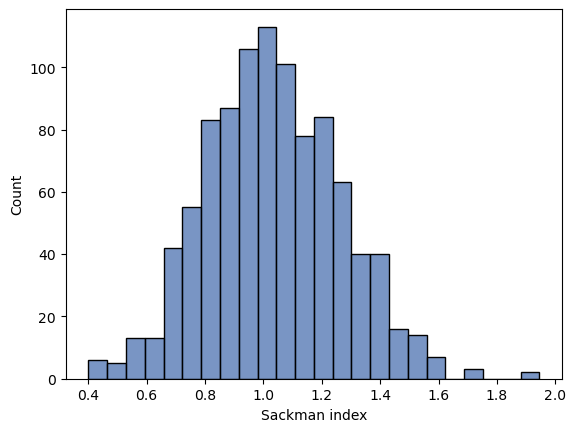

In [447]:
#distribution of court speeds 

dis = speeds.reset_index()

dis = dis[~dis['year'].isin([2003, 2004, 2005])]

sns.histplot(dis['observed_over_expected'])
plt.xlabel('Sackman index')

Text(0.5, 0, 'Sackman Index')

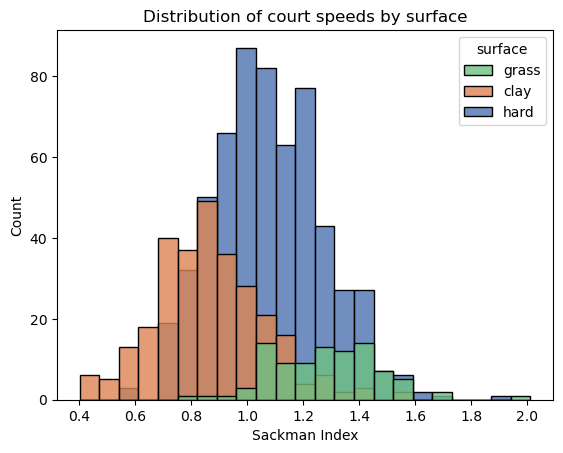

In [448]:
#Breaking down the distribution of court speeds by surface 

colors = [
          (0.4333333333333333, 0.7588235294117647, 0.50784313725490196),
          (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), 
          (0.2980392156862745, 0.4470588235294118, 0.6901960784313725) 
          ]

sns.histplot(data = dis, x = 'observed_over_expected', 
             hue = 'surface', palette= colors, binwidth=.07, alpha = .8, hue_order = ['grass', 'clay', 'hard']) 

plt.title('Distribution of court speeds by surface') 

plt.xlabel('Sackman Index') 

In [466]:
#I want some basic statistics 
dis['observed_over_expected'].describe()



count    971.000000
mean       1.034791
std        0.231809
min        0.400653
25%        0.872102
50%        1.021872
75%        1.193466
max        1.945556
Name: observed_over_expected, dtype: float64

Text(0, 0.5, 'Average court speed index')

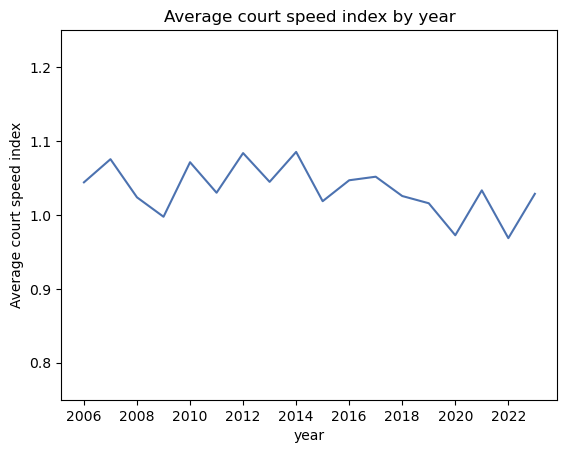

In [449]:
#I want speeds over time 

speeds_over_time = speeds.groupby('year').mean()

sns.set_palette('deep')
sns.lineplot(x = speeds_over_time.index[3:], y = speeds_over_time['observed_over_expected'].iloc[3:])
plt.xticks([2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022])
plt.ylim((.75, 1.25))
plt.title('Average court speed index by year')
plt.ylabel('Average court speed index')

In [453]:
#I want average court speed index by surface 
# hard speeds by year, excluding 2003 
surf_speeds = speeds.groupby(['year', 'surface']).mean()
hard_speeds = surf_speeds.xs('hard', level= 'surface')[3:]

clay_speeds = surf_speeds.xs('clay', level = 'surface')[3:]

grass_speeds = surf_speeds.xs('grass', level = 'surface')[3:]

Text(0, 0.5, 'Sackman index')

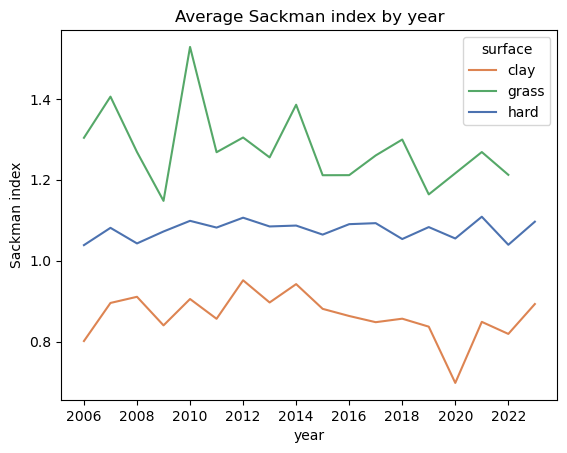

In [454]:
s = speeds.reset_index()
s = s.groupby(['year', 'surface']).mean()['observed_over_expected']
s = s.reset_index()

s = s[~s['year'].isin([2003, 2004, 2005])]

colors = [(0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
          (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
          (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
          ]

sns.lineplot(data = s, x = 'year', y = 'observed_over_expected', hue = 'surface', palette= colors)
plt.xticks([2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022])
plt.title('Average Sackman index by year')
plt.ylabel('Sackman index')

Text(0, 0.5, 'tournament count')

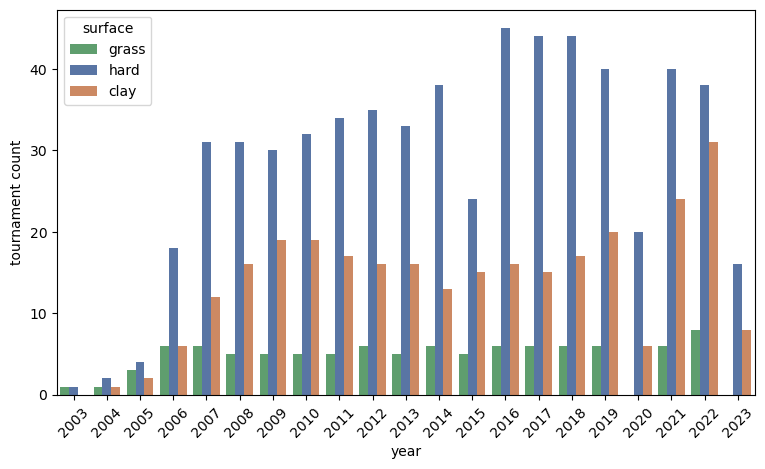

In [457]:
#NEED TO FIX
# figuring out how many observations each year has 

colors = [(0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
          (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
          (0.8666666666666667, 0.5176470588235295, 0.3215686274509804)]

fig, ax = plt.subplots(figsize = (9,5))
v = speeds.groupby(['year', 'surface']).count().iloc[1:]
v.reset_index(inplace= True, level= 'surface')

#resetting surface names because working with legends is tricky

#surf_map = {1: 'hard', 2:'grass', 0: 'clay'}

#v['surface'] = v['surface'].apply(lambda x: surf_map[x])

ax = sns.barplot(x = v.index, y = v['w_ace'], hue = v['surface'], palette= colors)
plt.xticks(rotation = 45)
plt.ylabel('tournament count')

#plt.legend(loc = 'upper left', labels = ['clay', 'hard', 'grass'])

# Courts which are surprisingly fast or slow

In [211]:
#Stuttgart has always been a fast tournament, despite being on clay. 
#You can see this in the results. For instance, Donna Vekic has done well 
#at Stuttgart despite not being a clay court player. 

speeds.xs('stuttgart', level= 'tourney_name')

,surface,w_avg_ace,w_ace,l_avg_ace,l_ace,total_expected_ace,total_observed_ace,observed_over_expected
year,,,,,,,,
2006,1,68.400890,92.0,58.079228,50.0,126.480118,142.0,1.122706
2007,1,75.331843,117.0,69.926034,60.0,145.257877,177.0,1.218523
2008,1,69.949381,102.0,66.109864,54.0,136.059245,156.0,1.146559
2009,0,82.287158,98.0,68.114994,47.0,150.402152,145.0,0.964082
2010,0,88.696201,126.0,100.259963,90.0,188.956164,216.0,1.143122
2011,0,126.146447,157.0,95.482996,94.0,221.629443,251.0,1.132521
2012,0,101.019145,151.0,86.125671,99.0,187.144816,250.0,1.335864
2013,0,121.025157,151.0,109.379415,87.0,230.404572,238.0,1.032966
2014,0,127.102421,191.0,115.120173,155.0,242.222593,346.0,1.428438


In [217]:
#in recent history, Wimbledon has been playing as a relatively slower grass court

speeds.xs('wimbledon', level = 'tourney_name')

,surface,w_avg_ace,w_ace,l_avg_ace,l_ace,total_expected_ace,total_observed_ace,observed_over_expected
year,,,,,,,,
2003,2,249.336941,393.0,189.669048,240.0,439.005988,633.0,1.441894
2004,2,150.943705,241.0,116.847524,133.0,267.791229,374.0,1.396610
2005,2,263.287688,345.0,218.197214,203.0,481.484902,548.0,1.138146
2006,2,246.833322,379.0,204.336940,227.0,451.170262,606.0,1.343174
2007,2,323.318744,440.0,240.406840,251.0,563.725584,691.0,1.225774
2008,2,329.444971,412.0,254.620705,259.0,584.065676,671.0,1.148843
2009,2,277.437094,393.0,240.485810,255.0,517.922904,648.0,1.251151
2010,2,268.836757,477.0,241.700657,328.0,510.537414,805.0,1.576770
2011,2,297.528073,448.0,270.980144,263.0,568.508218,711.0,1.250642


In [219]:
#Look at how the court speed index drops in 2017. This could look like noise, 
#but I think it captures something real. Nadal and Stephens, who both enjoy clay courts, 
#won the title in 2017. 

speeds.xs('usopen', level= 'tourney_name')

,surface,w_avg_ace,w_ace,l_avg_ace,l_ace,total_expected_ace,total_observed_ace,observed_over_expected
year,,,,,,,,
2003,1,270.915323,311.0,216.072906,208.0,486.988229,519.0,1.065734
2004,1,299.104054,398.0,241.568905,215.0,540.672959,613.0,1.133772
2005,1,218.118847,226.0,174.705580,118.0,392.824427,344.0,0.875709
2006,1,190.674769,262.0,157.470378,145.0,348.145148,407.0,1.169053
2007,1,287.944582,347.0,229.987788,179.0,517.932370,526.0,1.015577
2008,1,313.090796,371.0,254.670742,233.0,567.761538,604.0,1.063827
2009,1,297.254928,341.0,255.983832,219.0,553.238761,560.0,1.012221
2010,1,397.962158,465.0,388.979842,372.0,786.941999,837.0,1.063611
2011,1,525.853993,620.0,430.800659,396.0,956.654653,1016.0,1.062034


In [312]:
v = dis.pivot_table(index = 'tourney_name', columns = 'year', values = 'observed_over_expected') 

v = v[[2018, 2019, 2021, 2022]]

v.dropna(axis = 0, subset = [2021, 2022], inplace = True)

print(v.to_markdown())

| tourney_name   |       2018 |       2019 |     2021 |     2022 |
|:---------------|-----------:|-----------:|---------:|---------:|
| adelaide       | nan        | nan        | 1.03377  | 1.27703  |
| australianopen |   1.23954  |   1.16065  | 1.01931  | 1.04615  |
| badhomburg     | nan        | nan        | 1.2175   | 1.43639  |
| berlin         | nan        | nan        | 1.2806   | 1.32069  |
| birmingham     |   1.24254  |   1.06296  | 1.36124  | 1.26104  |
| bogota         |   0.672498 |   1.1474   | 0.590562 | 0.973021 |
| budapest       |   1.22952  |   1.08198  | 0.681096 | 0.7104   |
| charleston     |   0.847006 |   0.73097  | 0.896314 | 0.946238 |
| cincinnati     |   1.14981  |   1.25933  | 1.46456  | 1.24059  |
| cleveland      | nan        | nan        | 1.47366  | 1.0379   |
| clujnapoca     | nan        | nan        | 1.0564   | 1.18423  |
| doha           |   0.840921 |   0.890299 | 0.683376 | 0.964445 |
| dubai          |   0.953847 |   1.04601  | 0.889153 | 1.0968

Text(0.5, 1.0, 'Sackman index by year')

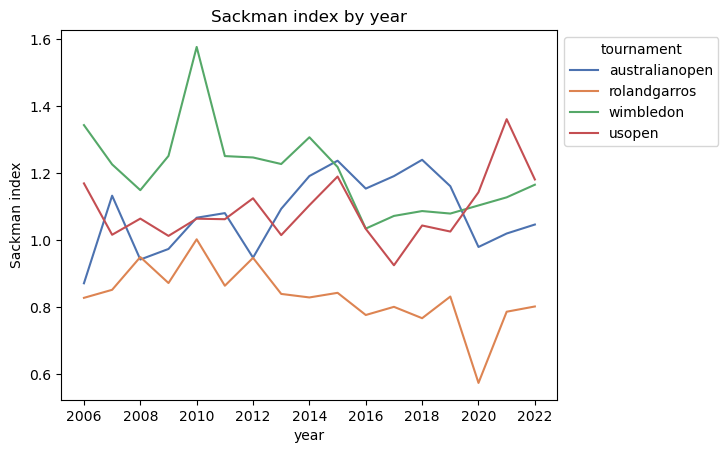

In [379]:
#graphing grand slam court speeds over time 

vi = dis.pivot_table(index = 'year', columns = 'tourney_name', values = 'observed_over_expected') 
vi = vi.drop([2023], axis = 0)

vi = vi[['australianopen', 'rolandgarros', 'wimbledon', 'usopen']]
vi.reset_index(inplace = True)


vi_melt = pd.melt(vi, id_vars = 'year', value_vars= ['australianopen', 'rolandgarros', 'wimbledon', 'usopen'], var_name= 'tournament', value_name = 'Sackman index')

ax = sns.lineplot(data = vi_melt, hue = 'tournament', x = 'year', y = 'Sackman index', linestyle = '-')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) 
plt.title('Sackman index by year')

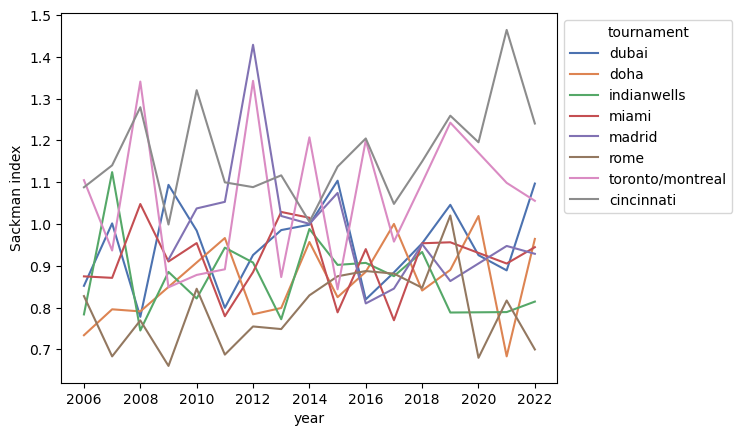

In [411]:


vie = dis.pivot_table(index = 'year', columns = 'tourney_name', values = 'observed_over_expected') 
vie = vie.drop([2023], axis = 0)
vie = vie[['dubai', 'doha', 'indianwells', 'miami', 'madrid', 'rome', 'toronto','montreal', 'cincinnati', ]]

vie.reset_index(inplace = True) 
vie['toronto/montreal'] = vie['toronto'].combine_first(vie['montreal'])
vie.drop(columns= ['toronto', 'montreal'], inplace = True)


vie = pd.melt(vie, id_vars = 'year', value_vars = ['dubai', 'doha', 'indianwells', 'miami', 'madrid', 'rome', 'toronto/montreal', 'cincinnati'],
               var_name='tournament', value_name = 'Sackman index')

ax = sns.lineplot(data = vie, hue = 'tournament', x = 'year', y = 'Sackman index', linestyle = '-')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) 

#vi = vi[['australianopen', 'rolandgarros', 'wimbledon', 'usopen']]
#vi.reset_index(inplace = True)


#vi_melt = pd.melt(vi, id_vars = 'year', value_vars= ['australianopen', 'rolandgarros', 'wimbledon', 'usopen'], var_name= 'tournament', value_name = 'Sackman index')

#ax = sns.lineplot(data = vi_melt x = 'year', y = 'Sackman index', linestyle = '-')
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1)) 
#plt.title('Sackman index by year')